# Create Experiment with VoDEx

In [1]:
from pathlib import Path
import vodex as vx

# for plotting :
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

## Adding information about the Volumes

You need to provide the folder with the data. Vodex will look into the folder, find all tiff files and assume it's one movie... so probably don't store any extra tiff files in that folder. It is generally a good idea to keed your raw data in a separate folder anyway. If you have to modify the order of the files or exclude some, yo ucan do too (not shown in this example, see FileManager class for more info on how to do it)

In [2]:
# data to create an experiment
TEST_DATA = "D:/Code/repos/vodex/data/test"
data_dir = Path(TEST_DATA, "test_movie")

Now give some information about the volumes. If your data is 2D - set frames_per_volume = 1 , it should work. 

In [3]:
frames_per_volume = 10
volume_m = vx.VolumeManager.from_dir(data_dir, frames_per_volume)
volume_m

Total frames : 42
Volumes start on frame : 0
Total good volumes : 4
Frames per volume : 10
Tailing frames (not a full volume , at the end) : 2

The output above looks good. The number of frames is 42, as it should be in the whole movie. You can look at the files  to make sure they are in the correct order : 

In [5]:
print(volume_m.file_manager)

Image files information :

files directory: D:\Code\repos\vodex\data\test\test_movie
files [number of frames]: 
0) mov0.tif [7]
1) mov1.tif [18]
2) mov2.tif [17]



The file order looks correct! 
## Initialise experiment
To load the volumes or access the annotation you will be using Experiment class. The rest of the calsses are just the helpers to initialise the Experiment. Let's create an experiment class that doesn't have any time annotation information for now. 

In [6]:
annotations = []
experiment = vx.Experiment.create(volume_m, annotations)
experiment.save("test.db")

Copied 24 of 24 pages...


Even though we didn't add any annotation , we can use it to simply load the volumes and not worry about what file they are coming from. 

In [8]:
# this gives you the volume list : 
# positive integer for each whole volume
# -1 if you have some extra frames at the beginning 
# -2 if there are some extra frames at the end , that don't form a whole volume
# also throws a warning if there are any of those extra frames
experiment.list_volumes()

D:\Code\repos\vodex\src\vodex\core.py:1148: UserWarning: The are some frames at the end of the recording that don't correspond to a full volume.
  warnings.warn(f"The are some frames at the end of the recording "


array([-2,  0,  1,  2,  3])

In [9]:
# so we have 4 full volumes : 0,1,2,3 and some extra frames at the end (-2)
# let's load two full volumes , 0 and 2: 
vol02 = experiment.load_volumes([0,2])
vol02.shape

(2, 10, 200, 200)

This will print out the two volumes, frame by frame : 

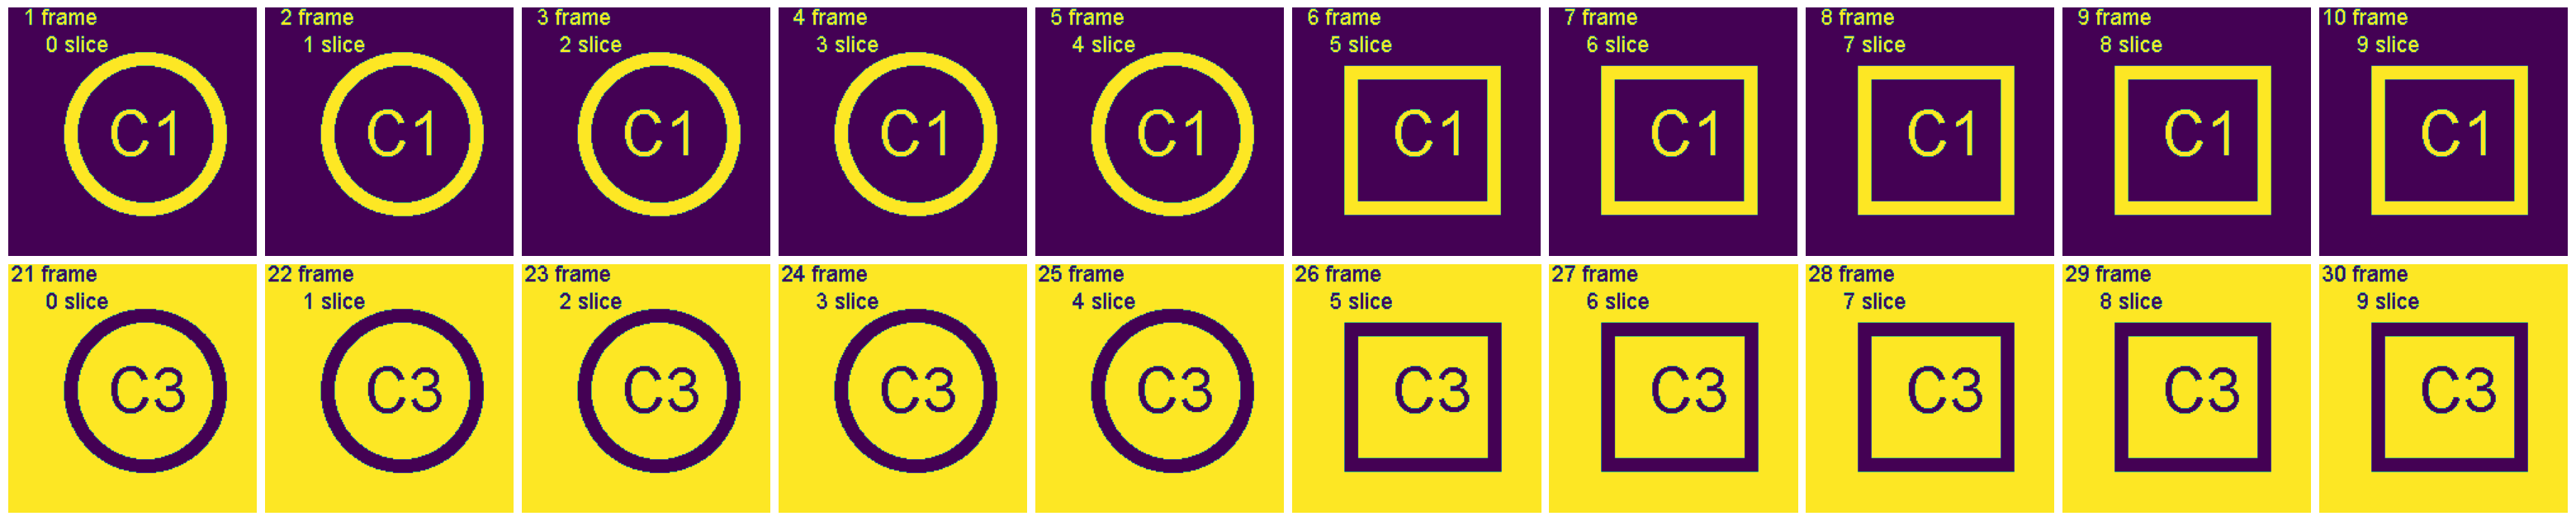

In [10]:
fig = plt.figure(figsize=(40., 200.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(2, 10),  
                 axes_pad=0.1,  
                 )

for ax, im in zip(grid, vol02.reshape((20,200,200))):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')
plt.show()

If you want to have a look at the rfames at the " tail" , you can do so by asking for the " volume -2"

In [11]:
volm2 = experiment.load_volumes([-2])
volm2.shape

(1, 2, 200, 200)

Notice how this volume only has 2 frames! 

## Adding the Time Annotation

To add the annotation, you will need to first specify the type of labels that you will be using. You don't have to specify all the annotations at once - you can add more to the experiment later. 

The Labels class needs the information about the "label group" , like what is it describing : light / drug/ sound/ visual stimuli ... and what values the labels can take in that group. Note , that there could be a group " light" with labels "on" and "off" and the label group "sound" with labels "on" and "off" as well.  Labels in different groups can have the same names , but labels per group should be distinct and the group names should be distinct as well... 

You can also add some optional discriptions, they are not needed for anything - but you might want to save them for your future self reference. 

In [13]:
c_label = vx.Labels(# label type ( group name), string
                    "c label", 
                    # label names, keep this brief
                    # same rules as for variable names:
                    # no leading numbers, no spaces, no special characters
                    ["c1", "c2", "c3"], 
                    # optional: info about the labels
                    # {label_name : label information}
                    state_info={"c1": "written c1", "c2": "written c1"})

shape = vx.Labels("shape", 
                  ["c", "s"],
                  state_info={"c": "circle on the screen", "s": "square on the screen"})

light = vx.Labels("light",
                  ["on", "off"],
                  state_info={"on": "the intensity of the background is high",
                           "off": "the intensity of the background is low"},
                 # optional: information about the group, string
                  group_info="Light on inverts the colors")

Now describe what's happening in terms of those labels that you've just made. You can use a cycle for the repeated labels; timeline if you ant to specify what label was active for how many frames , but it's not cyclic , and you can load an annotation from a csv (this feature actually doesn't work right now, but will be back soon ) 

In [15]:
c_label_cyc = vx.Cycle(# order of label presentation
                       # how they go in cycle 
                       [c_label.c1, c_label.c2, c_label.c3],
                       # duration of each presentation  
                       [10,10,10])
shape_cyc = vx.Cycle([shape.c, shape.s, shape.c],
                     [5,10,5])

light_tml = vx.Timeline(# order of label presentation 
                        # how they go in WHOLE RECORDING 
                        [light.off, light.on, light.off], 
                        # duration of each presentation
                        # for timeline: 
                        # the total duration MUST sum up 
                        # to the total number of frames in the recording
                        [10,20,12])
print(c_label_cyc)
print(shape_cyc)
print(light_tml)

Cycle : c label
Length: 30
Label c1: for 10 frames
Label c2: for 10 frames
Label c3: for 10 frames

Cycle : shape
Length: 20
Label c: for 5 frames
Label s: for 10 frames
Label c: for 5 frames

Timeline : light
Length: 42
Label off: for 10 frames
Label on: for 20 frames
Label off: for 12 frames



Now, using the cycles and timeline you've just created, make the annotatins. This would assign a label to each frame n the movie. You need to provide the total number of frames to do so ( Why? : think how the cycle would tile the whole movie, for example ) 

You can get the number of frames from the volume manager that you created earlier, or provide it by hand.

In [16]:
n_frames = volume_m.n_frames # 42
c_label_an = vx.Annotation.from_cycle(  # the total number of frames in the recording
                                        n_frames, 
                                        # the labels for the corresponding annotation
                                        c_label, 
                                        # the annotation itself: a cycle, a timeline or a file 
                                        c_label_cyc)
shape_an = vx.Annotation.from_cycle(n_frames, shape, shape_cyc)
light_an = vx.Annotation.from_timeline(n_frames, light, light_tml)
print(c_label_an)
print(shape_an)
print(light_an)

Annotation type: c label
Total frames : 42

Annotation type: shape
Total frames : 42

Annotation type: light
Total frames : 42



Add annotations to the experiment and rewrite the database that you saved earlier. 

In [17]:
experiment.add_annotations([shape_an, c_label_an, light_an])
experiment.save("test.db")

Copied 24 of 24 pages...


## Load volumes for certain conditions

You will use to methods for thie : "choose_volumes" to get the IDs of the volumes that correspond to the condition and then "load_volumes" to actually load them

In [12]:
# let's see what volumes correspond to light "off"
light_off_ids = experiment.choose_volumes([("light","off")], logic="and")
light_off_ids

[0, 3]

In [13]:
# how about light "off" and "on" (empty ... which makes sense :) can't be on AND off at the same time)
light_off_ids = experiment.choose_volumes([("light","off"),("light","on")], logic="and")
light_off_ids

[]

In [14]:
# while on OR off highlights all the whole volumes, whihc makes sense too :)
light_off_ids = experiment.choose_volumes([("light","off"),("light","on")], logic="or")
light_off_ids

[0, 1, 2, 3]

In [19]:
# you can go and experiment with this... 
light_off_ids = experiment.choose_volumes([("light","off"),("c label","c2")], logic="or")
light_off_ids

[0, 1, 3]

In [20]:
# load the volumes you've chosen 
vol_off_or_c2 = experiment.load_volumes(light_off_ids)
vol_off_or_c2.shape

(3, 10, 200, 200)